# Network utility functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil

import numpy as np
from scipy.stats import laplace
import matplotlib.pyplot as plt

from src.events.Events import (
    Events,
)
from src.events.tools.generation.pix2nvs import Pix2Eve
from src.events.tools.generation.stimuli_gen import (
    moving_lines,
    disparity_bars
)
from src.events.tools.modification.event_modification import (
    rectify_events,
    concatenate_npz,
)
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
import src.spiking_network.network.network_params as network_params
from src.spiking_network.network.neuvisys import (
    SpikingNetwork,
    delete_files,
    clean_network,
    shuffle_weights,
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    change_param,
    divide_visual_field,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

# network_path = home + "neuvisys-dv/configuration/network_ref_vh/"
network_path = home + "Desktop/Experiment/network_0/"

rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
disparities = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])

## CAUTION: Delete Weights

In [ ]:
clean_network("/home/thomas/Desktop/Experiment/network_0/", [0, 1])

## Network creation and launch

In [ ]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Experiment", 1)

In [9]:
launch_neuvisys_multi_pass("/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe",
                           "/home/thomas/Desktop/Experiment/network_0/configs/network_config.json",
                           "/home/thomas/Desktop/Events/left_e/vlines.npz", 1)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 9141600 events...
Saving Network...
Finished.


In [ ]:
# Launch training of multiple networks

n_networks = 100
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
networks_path = home + "Desktop/test/"
event_path = home + "Desktop/shapes.npz"

params = {"simple_cell_config": {"TARGET_SPIKE_RATE": [0.1, 0.2, 0.3]}}

create_networks(exec_path, networks_path, n_networks, params)
nb_iterations = 5

df = []

for i in range(0, n_networks):
    launch_neuvisys_multi_pass(
        exec_path, networks_path + "network_" + str(i) + "/configs/network_config.json", event_path, nb_iterations,
    )

    spinet = SpikingNetwork(networks_path + "network_" + str(i) + "/")
    # display_network([spinet], 0)
    # update_dataframe(df, spinet)

# df = pd.DataFrame(df)
# df.to_csv(home + "Desktop/test/df")

#### Orientation response

In [5]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
network_path = "/home/thomas/Desktop/Networks/lateral_weight_plot/network_0/"
event_rotation = home + "Videos/lines/rotations/"

spikes = [[], []]
for rot in rotations:
    launch_neuvisys_multi_pass(exec_path, network_path + "configs/network_config.json",
                               event_rotation + str(rot) + ".npz", 5)
    spinet = SpikingNetwork(network_path)
    spikes[0].append(spinet.spikes[0])
    spikes[1].append(spinet.spikes[1])
spinet.save_rotation_response(spikes, rotations)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45708000 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45688325 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45674725 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45679550 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45723900 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Feeding network: 45679575 events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from f

#### Disparity response

In [ ]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
network_path = home + "Desktop/network_experiment/"
event_disparity = home + "Videos/disparity/base_disp/"

spikes = [[], []]
for disp in disparities:
    launch_neuvisys_multi_pass(exec_path, network_path + "configs/network_config.json",
                               event_disparity + str(disp) + ".npz", 5)
    spinet = SpikingNetwork(network_path)
    spikes[0].append(spinet.spikes[0])
    spikes[1].append(spinet.spikes[1])
spinet.save_complex_disparities(spikes[1], disparities)

#### Inhibition weight learning

In [2]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
networks_path = home + "Desktop/Experiment/"
event_path = home + "Videos/disparity/"

# orientations
shapes = home + "Videos/shapes.npz"
h_events = home + "Videos/lines/hlines.npz"
v_events = home + "Videos/lines/vlines.npz"
vh_events = home + "Videos/lines/vhlines.npz"
sim_h = home + "Videos/lines/sim_h.npz"
sim_v = home + "Videos/lines/sim_v.npz"
sim_vh = home + "Videos/lines/sim_vh.npz"
rot_events = home + "Videos/lines/rotations.npz"
list_events_rot = [home + "Videos/lines/rotations/" + str(rotation) + ".npz" for rotation in rotations]

# disparity
events_0 = home + "Videos/disparity/disp_forward/0.npz"
list_disparities = [home + "Videos/disparity/disp_forward/" + str(disp) + ".npz" for disp in
                    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]]

In [4]:
create_networks(exec_path, networks_path, 1, network_params.disparity_9regions())

/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe: /home/thomas/miniconda3/envs/neuvisys-analysis/lib/libhdf5_cpp.so.103: no version information available (required by /home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe)
/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe: /home/thomas/miniconda3/envs/neuvisys-analysis/lib/libhdf5_cpp.so.103: no version information available (required by /home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe)
/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe: /home/thomas/miniconda3/envs/neuvisys-analysis/lib/libhdf5_cpp.so.103: no version information available (required by /home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe)
/home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe: /home/thomas/miniconda3/envs/neuvisys-analysis/lib/libhdf5_cpp.so.103: no version information available (required by /home/thomas/neuvisys-dv/cmake-build-release/neuvisys-exe)


##### learning the base network

In [28]:
## learning the base network
path = networks_path + "network_0/"

# draw = np.random.randint(-5, 6, size=300)
# for ind in draw:
#     launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", list_disparities[ind], 1)

# for i in range(100):
#     launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", "/home/thomas/Videos/DSEC/car.npz", 1)

for i in range(3):
    launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", sim_vh, 5)

Layer 0: new weights generated
Layer 1: new weights generated
Layer 2: new weights generated
Layer 3: new weights generated
Unpacking events...
Feeding network: 83705735 events...
19%
39%
59%
79%
98%
Saving Network...
Creating network state file
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 83705735 events...


KeyboardInterrupt: 

##### learning inhibition weights

(array([40., 23.,  7.,  5.,  3.,  4.,  1.,  0.,  1.,  0.,  0.,  4.,  7.,
        16.]),
 array([  1. ,  23.5,  46. ,  68.5,  91. , 113.5, 136. , 158.5, 181. ,
        203.5, 226. , 248.5, 271. , 293.5, 316. ]),
 <BarContainer object of 14 artists>)

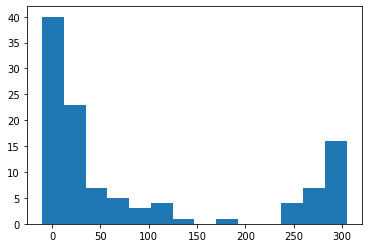

In [29]:
## learning inhibition weights
path = networks_path + "network_0/"

draw = np.round(laplace(0, 1.5).rvs(size=200)).astype(np.int64)
rotations_distribution = [list_events_rot[index] for index in draw if 16 > index > -17]

shutil.copytree(path, networks_path + "network_inhibition")
change_param(networks_path + "network_inhibition/configs/simple_cell_config.json", "STDP_LEARNING", "inhibitory")
change_param(networks_path + "network_inhibition/configs/complex_cell_config.json", "STDP_LEARNING", "none")

import re
distribution = ([int(re.findall('[0-9]+', string)[0]) for string in rotations_distribution])
plt.figure()
plt.hist(distribution, bins=np.arange(np.min(distribution) + 1, np.max(distribution) - 1, 22.5), align="left")

In [ ]:
np.save(networks_path + "network_inhibition/distribution", draw)

In [30]:
# for eventfile in rotations_distribution:
#     launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", eventfile, 1)

# for ind in draw:
#     launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", list_events_rot[int(ind)], 1)

for i in range(10):
    launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", sim_h, 5)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 35839615 events...
41%
83%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 35839615 events...
41%
83%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 35839615 events...
41%
83%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 35839615 events...
41%
83%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loa

In [31]:
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_control")
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_experiment")

change_param(networks_path + "network_control/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_control/configs/complex_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/complex_cell_config.json", "STDP_LEARNING", "none")

##### experiment

In [34]:
launch_neuvisys_multi_pass(exec_path, networks_path + "network_experiment/configs/network_config.json", sim_vh, 2)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 33482294 events...
49%
99%
Saving Network...
Finished.


##### control test

In [35]:
shuffle_weights(networks_path + "network_control/weights/0/")
launch_neuvisys_multi_pass(exec_path, networks_path + "network_control/configs/network_config.json", sim_vh, 2)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Layer 2: weights loaded from file
Layer 3: weights loaded from file
Unpacking events...
Feeding network: 33482294 events...
49%
99%
Saving Network...
Finished.


## Event manipulation:
Functions for loading, writing or creating event files in the different formats (aedat4, npz, rosbag...)

In [3]:
# Load events
events = Events("/home/thomas/Videos/dsec/interlaken_00_c/events/left/events.h5")

In [ ]:
list_events = [np.load("/home/thomas/Videos/disparity/0_disp.npz"), np.load("/home/thomas/Videos/disparity/4_disp.npz")]
concat_events = concatenate_npz(list_events)

In [ ]:
# Save aedat file as numpy npz file
# write_npz(home + "Desktop/shape_hovering_fast", events)  # mono
# write_npz(home + "Desktop/shapes", (left_events, right_events)) # stereo

Events("/home/thomas/Videos/left.npz", "/home/thomas/Videos/right.npz").save_file("/home/thomas/Videos/disparity/test")

In [ ]:
# Rectify events
rect_events = rectify_events((events[0].copy(), events[1].copy()), -5, -16, 5, 16)

In [ ]:
list_events = []
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    list_events.append(np.load("/home/thomas/Videos/lines/rotations/" + str(rotation) + ".npz"))
events = concatenate_npz(list_events)

In [ ]:
# write_npz("/home/thomas/Videos/rotations", events)

In [ ]:
events.event_to_video(50, "/home/thomas/Bureau/test.mp4", 346, 260)

In [2]:
for file in os.listdir("/home/thomas/Videos/dsec/"):
    print(file, ": \n", "loading left events...")
    events = Events("/home/thomas/Videos/dsec/"+file+"/events/left/events.h5")
    print("loading right events...")
    events.add_events("/home/thomas/Videos/dsec/"+file+"/events/right/events.h5", 1)
    # print("resizing events...")
    # events.resize_events(147, 110, 346, 260)
    print("sorting events...")
    events.sort_events()
    print("saving events...")
    events.save_as_file("/home/thomas/Videos/DSEC/"+file+".h5")

zurich_city_05_b : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_05_a : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_04_c : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_07_a : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_04_a : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_11_b : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_01_b : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_00_a : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_08_a : 
 loading left events...
loading right events...
sorting events...
saving events...
zurich_city_11_a : 
 loading left events...
loading right events...
sorti

## Frame manipulation

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

In [ ]:
rect_frames = rectify_frames(frames, -4, 8, 4, -8)

write_frames(
    "/home/alphat/Desktop/im1/", rect_frames, ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
)

In [ ]:
# Stereo matching
disp_frames, disp_nb_frames = stereo_matching(
    "/home/alphat/Desktop/pavin_images/im1/", [10, 84, 158, 232], [20, 83, 146], range(0, 200),
)

## Create event videos

Generate frames of the desired visual stimuli, then convert those frames into an event stream

In [4]:
framerate = 1000
time_gap = 1e6 * 1 / framerate
pix2eve = Pix2Eve(
    time_gap=time_gap,
    log_threshold=0,
    map_threshold=0.4,
    n_max=5,
    adapt_thresh_coef_shift=0,
    timestamp_noise=50
)
folder = home + "Desktop/Events/left_f/"

In [ ]:
disparity_bars(folder, disparities=[0, 0, 0, 0], framerate=framerate)
disparity_bars(folder, disparities=[8, 6, 4, 2], framerate=framerate)

In [ ]:
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    os.mkdir(folder + str(rotation) + "/")
    moving_lines(folder + str(rotation) + "/", time=2, rotation=rotation, framerate=framerate)

In [5]:
moving_lines(folder, time=2, framerate=framerate, rotation=0, disparity=0, frame_start=0)

In [6]:
print("Converting frames to event -> " + folder)

events = pix2eve.run("/home/thomas/Desktop/Events/left_f/")
events = events[events[:, 0].argsort()]
# write_npz(home + "Desktop/Events/left_e/vlines", events)

Converting frames to event -> /home/thomas/Desktop/Events/left_f/
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion


In [ ]:
folder = home + "Desktop/Events/"

moving_lines(folder + "left_f/", time=2, framerate=framerate, speed=-200, rotation=0, disparity=0, frame_start=0)
events = pix2eve.run(folder + "left_f/")
events = events[events[:, 0].argsort()]
# write_npz(folder + "/left_e/0", events)

for i in range(-8, 9):
    moving_lines(folder + "right_f/", time=2, framerate=framerate, speed=-200, rotation=0, disparity=i, frame_start=0)
    events = pix2eve.run(folder + "right_f/")
    events = events[events[:, 0].argsort()]
    # write_npz(folder + "/right_e/" + str(i), events)
    delete_files(folder + "right_f/")
    Events(folder + "left_e/0.npz", folder + "right_e/" + str(i) + ".npz").save_file(folder + str(i))

## Divide visual field

In [8]:
print(divide_visual_field(3, 3, 40, 40))

([93.0], [50.0])
